# Image Translation using Conditional GAN (Pix2Pix)

![Pix2Pix Architecture](https://i.imgur.com/a3uAqnb.png)

In this homework, you will implement a **Conditional Image-to-Image GAN** for translating edge images to shoe images. This is based on the **Pix2Pix** architecture that learns to map from one image domain to another.

## 📌 Project Overview
- **Task**: Edge-to-Shoe image translation
- **Architecture**: Conditional GAN with U-Net Generator and PatchGAN Discriminator
- **Dataset**: Edge2Shoes dataset from Kaggle
- **Goal**: Generate realistic shoe images from edge sketches

---

## 1️⃣ Dataset Download and Setup

First, let's download the dataset and set up our environment.


In [1]:
import kagglehub
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Download latest version of Edge2Shoes dataset
path = kagglehub.dataset_download("balraj98/edges2shoes-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/habiam0b/.cache/kagglehub/datasets/balraj98/edges2shoes-dataset/versions/1



## 2️⃣ Import Libraries and Configuration

In [19]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import glob
from tqdm import tqdm
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 🔹 Configuration Parameters
IMG_SIZE = 128  # Image size (must be power of 2: 64, 128, 256, 512)
BATCH_SIZE = 128
LEARNING_RATE = 0.0002
BETA1 = 0.5  # Adam optimizer beta1 parameter
BETA2 = 0.999  # Adam optimizer beta2 parameter
LAMBDA_L1 = 100  # Weight for L1 loss in generator
NUM_EPOCHS = 3

# Validate image size
if IMG_SIZE & (IMG_SIZE - 1) != 0:
    raise ValueError("IMG_SIZE must be a power of 2 (e.g., 64, 128, 256, 512)")

print(f"Image size set to: {IMG_SIZE}x{IMG_SIZE}")

Using device: cuda
Image size set to: 128x128




## 3️⃣ Custom Dataset Class

The Edge2Shoes dataset contains combined images (edge + shoe side by side). We need to split them.


In [20]:
# Custom Dataset Class for Edge-to-Shoe Translation
class EdgeShoeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Dataset class for Edge2Shoes dataset

        Args:
            root_dir: Directory containing the dataset images
            transform: Image transformations to apply
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = glob.glob(os.path.join(root_dir, "*.jpg"))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        # 🔹 Split the image into edge (left) and shoe (right)
        width, height = image.size
        edge_img = image.crop((0, 0, width//2, height))  # Left half
        shoe_img = image.crop((width//2, 0, width, height))  # Right half

        if self.transform:
            edge_img = self.transform(edge_img)
            shoe_img = self.transform(shoe_img)

        return edge_img, shoe_img

## 4️⃣ Data Preprocessing and Loading


In [21]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Resize to target size
    transforms.ToTensor(),  # Convert to tensor [0,1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Create datasets
train_dataset = EdgeShoeDataset(os.path.join(path, 'train'), transform=transform)
val_dataset = EdgeShoeDataset(os.path.join(path, 'val'), transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Test the dataset
sample_edge, sample_shoe = train_dataset[0]
print(f"Edge image shape: {sample_edge.shape}")
print(f"Shoe image shape: {sample_shoe.shape}")

Training samples: 49825
Validation samples: 200
Edge image shape: torch.Size([3, 128, 128])
Shoe image shape: torch.Size([3, 128, 128])




## 5️⃣ Generator Network (U-Net Architecture)

The **Generator** uses a **U-Net architecture** with skip connections for better detail preservation.

### 📌 U-Net Structure:
1️⃣  **Encoder** → Compresses input to bottleneck

2️⃣  **Decoder** → Reconstructs output with skip connections

3️⃣  **Skip Connections** → Preserve fine details


In [22]:
# U-Net Building Block
class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_dropout=False, use_batchnorm=True):
        """
        U-Net building block for encoder/decoder layers

        Args:
            in_channels: Input channels
            out_channels: Output channels
            down: True for encoder (downsampling), False for decoder (upsampling)
            use_dropout: Whether to apply dropout
            use_batchnorm: Whether to apply batch normalization
        """
        super(UNetBlock, self).__init__()
        layers = []

        if down:
            # Encoder: Convolution with stride 2 for downsampling
            layers.append(nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False))
        else:
            # Decoder: Transpose convolution with stride 2 for upsampling
            layers.append(nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False))

        if use_batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))

        self.conv = nn.Sequential(*layers)
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

# Dynamic Generator Network (U-Net)
class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, img_size=256):
        """
        U-Net Generator for image-to-image translation

        Args:
            in_channels: Input image channels (3 for RGB)
            out_channels: Output image channels (3 for RGB)
            img_size: Image size (must be power of 2)
        """
        super(Generator, self).__init__()

        self.img_size = img_size

        # 🔹 Calculate number of layers based on image size
        if img_size == 64:
            self.num_down = 5  # 64→32→16→8→4→2
            self.num_up = 4    # 2→4→8→16→32, then final: 32→64
        elif img_size == 128:
            self.num_down = 6  # 128→64→32→16→8→4→2
            self.num_up = 5    # 2→4→8→16→32→64, then final: 64→128
        elif img_size == 256:
            self.num_down = 7  # 256→128→64→32→16→8→4→2
            self.num_up = 6    # 2→4→8→16→32→64→128, then final: 128→256
        else:
            self.num_down = int(np.log2(img_size)) - 1
            self.num_up = self.num_down - 1

        # 🔹 Encoder (Downsampling Path)
        encoder_layers = []
        nf = 64  # Number of filters

        # First encoder layer (no BatchNorm)
        encoder_layers.append(nn.Conv2d(in_channels, nf, 4, 2, 1))

        # Rest of encoder layers
        for i in range(1, self.num_down):
            nf_next = min(512, nf * 2)  # Cap at 512 filters
            encoder_layers.append(UNetBlock(nf, nf_next, down=True, use_batchnorm=True))
            nf = nf_next

        self.encoders = nn.ModuleList(encoder_layers)

        # 🔹 Decoder (Upsampling Path with Skip Connections)
        decoder_layers = []

        # First decoder (from bottleneck, no skip connection)
        decoder_layers.append(UNetBlock(nf, nf, down=False, use_dropout=True, use_batchnorm=True))

        # Rest of decoder layers (with skip connections)
        for i in range(self.num_up - 1):
            # Calculate skip channels from encoder layers (in reverse order)
            skip_layer_idx = self.num_down - 2 - i

            if skip_layer_idx == 0:
                nf_skip = 64  # First encoder output
            else:
                nf_skip = min(512, 64 * (2 ** skip_layer_idx))

            nf_in = nf + nf_skip  # Current + skip connection
            nf_out = nf_skip

            use_dropout = len(decoder_layers) < 3  # Dropout in first few layers
            decoder_layers.append(UNetBlock(nf_in, nf_out, down=False, use_dropout=use_dropout, use_batchnorm=True))
            nf = nf_out

        self.decoders = nn.ModuleList(decoder_layers)

        # 🔹 Final layer - outputs the target image
        final_input_channels = nf + 64  # Current + first encoder skip
        self.final = nn.Sequential(
            nn.ConvTranspose2d(final_input_channels, out_channels, 4, 2, 1),
            nn.Tanh()  # Output in range [-1, 1]
        )

        print(f"Generator for {img_size}x{img_size}: {self.num_down} down, {len(decoder_layers)} up, final layer")
        print(f"Final input channels: {final_input_channels}")

    def forward(self, x):
        # 🔹 Encoder forward pass
        encoder_outs = []
        current = x
        for i, encoder in enumerate(self.encoders):
            current = encoder(current)
            encoder_outs.append(current)

        # 🔹 Decoder forward pass with skip connections
        current = encoder_outs[-1]  # Start from bottleneck

        # First decoder (no skip)
        current = self.decoders[0](current)

        # Rest with skip connections (in reverse order)
        for i, decoder in enumerate(self.decoders[1:]):
            skip_idx = len(encoder_outs) - 2 - i  # Skip from encoder layers
            skip = encoder_outs[skip_idx]
            current = torch.cat([current, skip], 1)  # Concatenate skip connection
            current = decoder(current)

        # Final layer with first encoder skip
        current = torch.cat([current, encoder_outs[0]], 1)
        output = self.final(current)

        return output

# Initialize and test generator
generator = Generator(img_size=IMG_SIZE).to(device)
print(f"Generator parameters: {sum(p.numel() for p in generator.parameters()):,}")

# Test the generator
test_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)
generator.eval()
with torch.no_grad():
    test_output = generator(test_input)
    print(f"Test: {test_input.shape} -> {test_output.shape}")
    if test_output.shape[2] == IMG_SIZE and test_output.shape[3] == IMG_SIZE:
        print(f"✅ SUCCESS: Output size matches target {IMG_SIZE}x{IMG_SIZE}")
    else:
        print(f"❌ ERROR: Output size doesn't match target {IMG_SIZE}x{IMG_SIZE}")
generator.train()

Generator for 128x128: 6 down, 5 up, final layer
Final input channels: 192
Generator parameters: 36,064,835
Test: torch.Size([1, 3, 128, 128]) -> torch.Size([1, 3, 128, 128])
✅ SUCCESS: Output size matches target 128x128


Generator(
  (encoders): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): UNetBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (2): UNetBlock(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (3): UNetBlock(
      (conv): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

## 6️⃣ Discriminator Network (PatchGAN)

The **Discriminator** uses a **PatchGAN architecture** that classifies image patches as real/fake instead of the entire image.

### 📌 PatchGAN Benefits:
- **Local Assessment** → Focuses on local image structure
- **Faster Training** → Smaller receptive field
- **Better Details** → Encourages fine-grained realism

In [23]:
# Dynamic Discriminator Network (PatchGAN)
class Discriminator(nn.Module):
    def __init__(self, in_channels=6, img_size=256):  # 3 for edge + 3 for shoe
        """
        PatchGAN Discriminator for conditional image generation

        Args:
            in_channels: Input channels (6 = 3 edge + 3 shoe)
            img_size: Image size for dynamic layer calculation
        """
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Create a discriminator block with Conv2d, BatchNorm, and LeakyReLU"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, 2, 1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        # 🔹 Calculate number of layers based on image size
        if img_size <= 64:
            num_layers = 3  # 64→32→16→8
        elif img_size <= 128:
            num_layers = 4  # 128→64→32→16→8
        elif img_size <= 256:
            num_layers = 4  # 256→128→64→32→16
        else:
            num_layers = 5

        layers = []

        # First layer (no normalization)
        layers.extend(discriminator_block(in_channels, 64, normalize=False))

        # Add intermediate layers
        in_filters = 64
        for i in range(num_layers - 1):
            out_filters = min(512, in_filters * 2)  # Cap at 512 filters
            layers.extend(discriminator_block(in_filters, out_filters))
            in_filters = out_filters

        # Final layer - outputs patch classifications
        layers.append(nn.Conv2d(in_filters, 1, 4, 1, 1))

        self.model = nn.Sequential(*layers)

        # 🔹 Calculate actual output size by running a test forward pass
        with torch.no_grad():
            test_input = torch.randn(1, in_channels, img_size, img_size)
            test_output = self.model(test_input)
            self.output_size = test_output.shape[2]  # Height and width should be same

        print(f"Discriminator for {img_size}x{img_size}: {num_layers} layers, output size: {self.output_size}x{self.output_size}")

    def forward(self, img_A, img_B):
        """
        Forward pass through discriminator

        Args:
            img_A: Input image (edge)
            img_B: Target/Generated image (shoe)

        Returns:
            Patch-wise real/fake predictions
        """
        # Concatenate input and target images by channels
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

# Initialize and test discriminator
discriminator = Discriminator(img_size=IMG_SIZE).to(device)
print(f"Discriminator parameters: {sum(p.numel() for p in discriminator.parameters()):,}")

# Test discriminator
test_edge = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)
test_shoe = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)
with torch.no_grad():
    test_disc_output = discriminator(test_edge, test_shoe)
    print(f"Discriminator test: {test_edge.shape} + {test_shoe.shape} -> {test_disc_output.shape}")
    print(f"✅ Discriminator output size: {test_disc_output.shape[2]}x{test_disc_output.shape[3]}")

Discriminator for 128x128: 4 layers, output size: 7x7
Discriminator parameters: 2,769,601
Discriminator test: torch.Size([1, 3, 128, 128]) + torch.Size([1, 3, 128, 128]) -> torch.Size([1, 1, 7, 7])
✅ Discriminator output size: 7x7



## 7️⃣ Loss Functions and Optimizers

### 📌 Loss Functions:
1️⃣ **Adversarial Loss** (BCE) → Makes generated images realistic

2️⃣ **L1 Loss** → Preserves pixel-level details

3️⃣ **Combined Loss** → Balances realism and accuracy


In [24]:
# Loss functions
criterion_GAN = nn.BCEWithLogitsLoss()  # Adversarial loss
criterion_L1 = nn.L1Loss()  # Pixel-wise reconstruction loss

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))

# Weight initialization function
def weights_init(m):
    """Initialize network weights"""
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Apply weight initialization
generator.apply(weights_init)
discriminator.apply(weights_init)

print("Models initialized successfully!")

Models initialized successfully!



## 8️⃣ Training Loop

### 📌 Training Process:
1️⃣ **Train Generator** → Minimize adversarial + L1 loss

2️⃣ **Train Discriminator** → Distinguish real from fake

3️⃣ **Alternate Training** → Generator and discriminator compete

In [25]:
# Dynamic Training Loop
def train_epoch(epoch):
    """Train one epoch of the GAN"""
    generator.train()
    discriminator.train()

    running_loss_G = 0.0
    running_loss_D = 0.0

    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS}')

    for i, (edge_imgs, real_shoes) in enumerate(progress_bar):
        edge_imgs = edge_imgs.to(device)
        real_shoes = real_shoes.to(device)

        batch_size = edge_imgs.size(0)

        # 🔹 Dynamic labels based on discriminator output size
        d_output_size = discriminator.output_size
        valid = torch.ones(batch_size, 1, d_output_size, d_output_size, device=device, requires_grad=False)
        fake = torch.zeros(batch_size, 1, d_output_size, d_output_size, device=device, requires_grad=False)

        # ---------------------
        #  🔹 Train Generator
        # ---------------------
        optimizer_G.zero_grad()

        # Generate fake shoes from edge images
        fake_shoes = generator(edge_imgs)

        # Adversarial loss (fool discriminator)
        pred_fake = discriminator(edge_imgs, fake_shoes)
        loss_GAN = criterion_GAN(pred_fake, valid)

        # L1 loss (pixel-wise similarity)
        loss_L1 = criterion_L1(fake_shoes, real_shoes)

        # Total generator loss
        loss_G = loss_GAN + LAMBDA_L1 * loss_L1
        loss_G.backward()
        optimizer_G.step()

        # ---------------------
        #  🔹 Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Real loss (classify real images as real)
        pred_real = discriminator(edge_imgs, real_shoes)
        loss_real = criterion_GAN(pred_real, valid)

        # Fake loss (classify fake images as fake)
        pred_fake = discriminator(edge_imgs, fake_shoes.detach())
        loss_fake = criterion_GAN(pred_fake, fake)

        # Total discriminator loss
        loss_D = (loss_real + loss_fake) / 2
        loss_D.backward()
        optimizer_D.step()

        running_loss_G += loss_G.item()
        running_loss_D += loss_D.item()

        # Update progress bar
        progress_bar.set_postfix({
            'G_loss': f'{loss_G.item():.4f}',
            'D_loss': f'{loss_D.item():.4f}',
            'L1_loss': f'{loss_L1.item():.4f}'
        })

    return running_loss_G / len(train_loader), running_loss_D / len(train_loader)


In [27]:
# 🔹 Start Training
train_losses_G = []
train_losses_D = []

print(f"Starting training for {IMG_SIZE}x{IMG_SIZE} images...")
for epoch in range(NUM_EPOCHS):
    loss_G, loss_D = train_epoch(epoch)
    train_losses_G.append(loss_G)
    train_losses_D.append(loss_D)

    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}] - G_loss: {loss_G:.4f}, D_loss: {loss_D:.4f}')

    # Save sample images every 2 epochs
    if (epoch + 1) % 2 == 0:
        generator.eval()
        with torch.no_grad():
            sample_edge, sample_shoe = val_dataset[0]
            sample_edge = sample_edge.unsqueeze(0).to(device)
            sample_shoe = sample_shoe.unsqueeze(0).to(device)

            fake_shoe = generator(sample_edge)

            # Denormalize images for visualization
            sample_edge_denorm = (sample_edge + 1) / 2
            sample_shoe_denorm = (sample_shoe + 1) / 2
            fake_shoe_denorm = (fake_shoe + 1) / 2

            # Save comparison
            comparison = torch.cat([sample_edge_denorm, fake_shoe_denorm, sample_shoe_denorm], dim=3)
            save_image(comparison, f'sample_epoch_{epoch+1}_{IMG_SIZE}.png', nrow=1, padding=2)

print("Training completed!")

Starting training for 128x128 images...


Epoch 1/3: 100%|███████████████████████| 390/390 [02:15<00:00,  2.87it/s, G_loss=19.0675, D_loss=0.3076, L1_loss=0.1748]


Epoch [1/3] - G_loss: 20.5589, D_loss: 0.4862


Epoch 2/3: 100%|███████████████████████| 390/390 [02:16<00:00,  2.85it/s, G_loss=15.3657, D_loss=0.4611, L1_loss=0.1464]


Epoch [2/3] - G_loss: 16.2040, D_loss: 0.5550


Epoch 3/3: 100%|███████████████████████| 390/390 [02:17<00:00,  2.84it/s, G_loss=16.1870, D_loss=0.7180, L1_loss=0.1475]

Epoch [3/3] - G_loss: 14.9609, D_loss: 0.5516
Training completed!


## 9️⃣ Plot Training Results

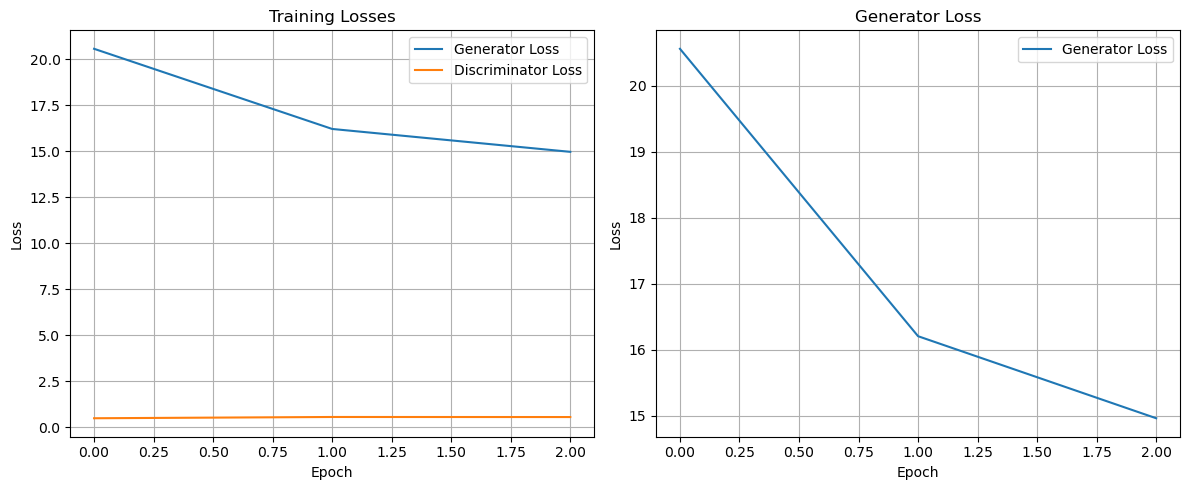

In [28]:
# Plot training loss curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_G, label='Generator Loss')
plt.plot(train_losses_D, label='Discriminator Loss')
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_losses_G, label='Generator Loss')
plt.title('Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 🔟 Evaluation: Edge-to-Shoe Translations

### 📌 Show 10 translations from validation set


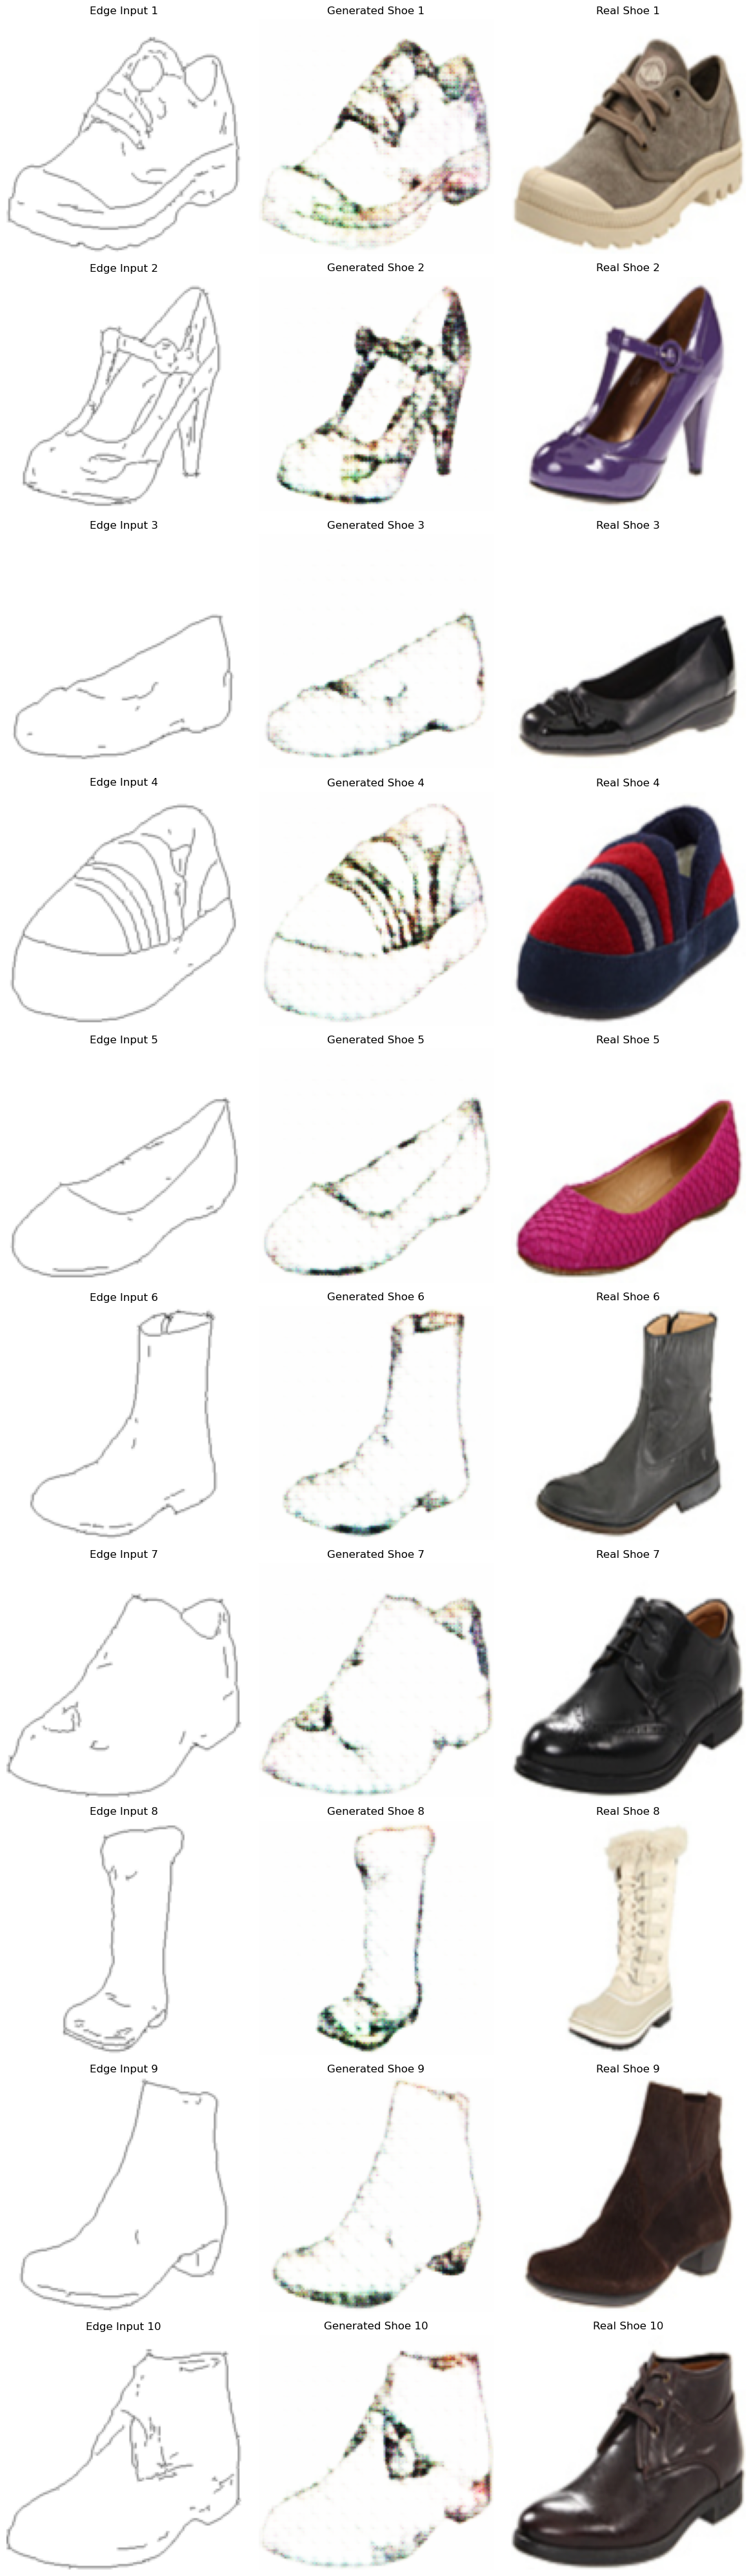

In [29]:
# Show 10 edge to shoes translations from validation set
generator.eval()

def denormalize(tensor):
    """Denormalize tensor from [-1, 1] to [0, 1]"""
    return (tensor + 1) / 2

def show_translations(num_samples=10):
    """Display original edges, generated shoes, and real shoes"""
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))

    with torch.no_grad():
        for i in range(num_samples):
            # Get validation sample
            edge_img, real_shoe = val_dataset[i]
            edge_img = edge_img.unsqueeze(0).to(device)
            real_shoe = real_shoe.unsqueeze(0).to(device)

            # Generate fake shoe
            fake_shoe = generator(edge_img)

            # Convert to numpy for visualization
            edge_np = denormalize(edge_img.squeeze(0).cpu()).permute(1, 2, 0).numpy()
            fake_np = denormalize(fake_shoe.squeeze(0).cpu()).permute(1, 2, 0).numpy()
            real_np = denormalize(real_shoe.squeeze(0).cpu()).permute(1, 2, 0).numpy()

            # Plot results
            axes[i, 0].imshow(edge_np)
            axes[i, 0].set_title(f'Edge Input {i+1}')
            axes[i, 0].axis('off')

            axes[i, 1].imshow(fake_np)
            axes[i, 1].set_title(f'Generated Shoe {i+1}')
            axes[i, 1].axis('off')

            axes[i, 2].imshow(real_np)
            axes[i, 2].set_title(f'Real Shoe {i+1}')
            axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# 🔹 Display Results
show_translations(10)

## 1️⃣1️⃣ Test on Custom Sketches


Testing model on custom sketches...


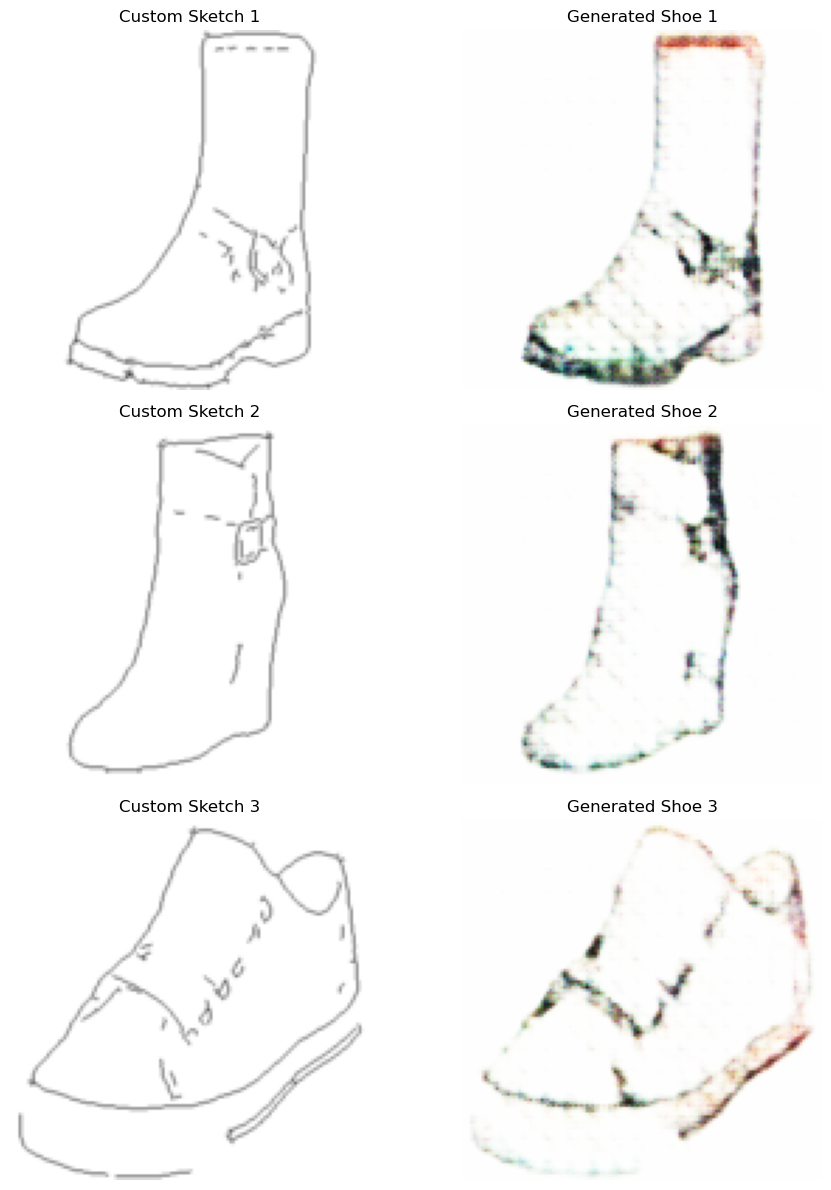

\nModel testing completed!


In [30]:
# Function to create simple sketches (using validation samples as examples)
def create_simple_sketches():
    """Create or load custom sketches for testing"""
    # For this example, we'll use validation samples as "custom sketches"
    return "Using validation samples as custom sketches"

# Test with custom sketches
print("Testing model on custom sketches...")
custom_sketches = create_simple_sketches()

fig, axes = plt.subplots(3, 2, figsize=(10, 12))

for i in range(3):
    # Use validation samples as "custom sketches"
    edge_img, _ = val_dataset[i + 10]
    edge_img = edge_img.unsqueeze(0).to(device)

    with torch.no_grad():
        fake_shoe = generator(edge_img)

    sketch_np = denormalize(edge_img.squeeze(0).cpu()).permute(1, 2, 0).numpy()
    fake_np = denormalize(fake_shoe.squeeze(0).cpu()).permute(1, 2, 0).numpy()

    axes[i, 0].imshow(sketch_np)
    axes[i, 0].set_title(f'Custom Sketch {i+1}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(fake_np)
    axes[i, 1].set_title(f'Generated Shoe {i+1}')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

print("\\nModel testing completed!")

## 1️⃣2️⃣ Save Model and Training Summary


In [31]:
# Save the trained model
torch.save({
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'optimizer_G_state_dict': optimizer_G.state_dict(),
    'optimizer_D_state_dict': optimizer_D.state_dict(),
    'train_losses_G': train_losses_G,
    'train_losses_D': train_losses_D,
    'config': {
        'IMG_SIZE': IMG_SIZE,
        'BATCH_SIZE': BATCH_SIZE,
        'LEARNING_RATE': LEARNING_RATE,
        'LAMBDA_L1': LAMBDA_L1,
        'NUM_EPOCHS': NUM_EPOCHS
    }
}, f'pix2pix_edge2shoe_model_{IMG_SIZE}.pth')

print("Model saved successfully!")

# Function to load the model
def load_model(model_path, img_size=None):
    """Load a saved Pix2Pix model"""
    checkpoint = torch.load(model_path, map_location=device)

    # Get image size from config or parameter
    if img_size is None:
        img_size = checkpoint['config']['IMG_SIZE']

    # Initialize models
    gen = Generator(img_size=img_size).to(device)
    disc = Discriminator(img_size=img_size).to(device)

    # Load state dictionaries
    gen.load_state_dict(checkpoint['generator_state_dict'])
    disc.load_state_dict(checkpoint['discriminator_state_dict'])

    return gen, disc, checkpoint['train_losses_G'], checkpoint['train_losses_D']

# 🔹 Training Summary
print("\\nTraining Summary:")
print(f"- Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"- Total epochs: {NUM_EPOCHS}")
print(f"- Final Generator loss: {train_losses_G[-1]:.4f}")
print(f"- Final Discriminator loss: {train_losses_D[-1]:.4f}")
print(f"- Training dataset size: {len(train_dataset)}")
print(f"- Validation dataset size: {len(val_dataset)}")
print(f"- Batch size: {BATCH_SIZE}")
print(f"- Learning rate: {LEARNING_RATE}")
print(f"- L1 lambda: {LAMBDA_L1}")
print(f"- Discriminator output size: {discriminator.output_size}x{discriminator.output_size}")

Model saved successfully!
\nTraining Summary:
- Image size: 128x128
- Total epochs: 3
- Final Generator loss: 14.9609
- Final Discriminator loss: 0.5516
- Training dataset size: 49825
- Validation dataset size: 200
- Batch size: 128
- Learning rate: 0.0002
- L1 lambda: 100
- Discriminator output size: 7x7


## 📝 Exercise Ideas

### 🔹 **Experiment with Hyperparameters**
- Try different **lambda values** for L1 loss (10, 50, 200)
- Experiment with **image sizes** (128, 256, 512)
- Test different **learning rates** and **batch sizes**

### 🔹 **Architecture Modifications**
- Add **attention mechanisms** to the generator
- Try different **normalization techniques** (InstanceNorm, GroupNorm)
- Experiment with **different activation functions**

### 🔹 **Dataset Experiments**
- Train on **different image translation tasks** (maps, facades, etc.)
- Try **data augmentation** techniques
- Experiment with **different preprocessing** approaches

### Contributed by: Ali Habibullah